# Part 1: Data Cleaning And Visualizations

## Imports

In [1]:
import pandas                            as pd
import numpy                             as np
import seaborn                           as sns
import matplotlib.pyplot                 as plt
from fancyimpute                         import KNN
from IPython.core.display                import display, HTML
sns.set(style = "white", palette = "husl")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Using TensorFlow backend.
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Table Of Contents


1. [Data Cleaning](#Data-Cleaning)

    - [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    - [Columns](#Columns)
    - [Ordinal & Nominal Values](#Ordinal-&-Nominal-Values)
    - [Imputation Of Missing Data](#Imputation-Of-Missing-Data)
    - [Saving A New Dataframe](#Saving-A-New-Dataframe)
    

2. [Exploratory Visualizations](#Exploratory-Visualizations)
    - [Numeric Data](#Numeric-Data)
        - [Functions](#Functions)
        - [Histograms](#Histograms)
        - [Box Plots](#Box-Plots)
        - [Scatter Plots](#Scatter-Plots)
    - [Ordinal Data](#Ordinal-Data)
        - [Functions](#Functions)
        - [Bar Plots](#Bar-Plots)
        

3. [Heat Map](#Heat-Map)

## Data Cleaning

### Reading In The Data

In [2]:
# Reading in the MRI data file

mri = pd.read_csv("../Data/stress_cardiac_mri.csv")

### Overview

In [3]:
# Looking at the head of the data frame

mri.head()

,Name,"Sex (1=male,0=female)",Age,"Hypertension (1=yes,0=no)",Hyperlipidemia,Diabetes,History of smoking,LVEDV,LVESV,LV Wall Thickness,...,MA_Ischemia,MAS_Ischemia,MIS_Ischemia,MI_Ischemia,MIL_Ischemia,MAL_Ischemia,AA_Ischemia,AS_Ischemia,AI_Ischemia,AL_Ischemia
0,CloudCMR-35423,1,37,0,0,No,Never,613.0,501.0,Normal,...,0,0,0,0,0,0,0,0,0,0
1,CloudCMR-24662,1,74,0,1,No,Never,569.0,492.0,MILD HYPERTROPHY,...,0,0,0,0,0,0,0,1,0,1
2,CloudCMR-25620,1,78,1,1,Yes,Never,564.0,500.0,Normal,...,1,1,1,1,0,0,1,1,0,0
3,CloudCMR-21728,1,61,0,1,No,Never,531.0,435.0,MILD HYPERTROPHY,...,0,0,0,0,0,0,0,0,0,0
4,CloudCMR-49141,1,53,0,0,No,Current,522.2,408.6,Normal,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Checking the shape of the data

print(f'The shape of the mri set is: {mri.shape}')

The shape of the mri set is: (6494, 48)


In [5]:
# Getting the data types

mri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 48 columns):
Name                                                                                                                   6494 non-null object
Sex (1=male,0=female)                                                                                                  6494 non-null int64
Age                                                                                                                    6494 non-null int64
Hypertension (1=yes,0=no)                                                                                              6494 non-null int64
Hyperlipidemia                                                                                                         6494 non-null int64
Diabetes                                                                                                               6458 non-null object
History of smoking                                       

In [6]:
# Sum of the data types

mri.dtypes.value_counts()

int64      37
object      6
float64     5
dtype: int64

In [7]:
# Description Of Columns With Continuous/Discrete Data

columns = ["Age", "LVEDV", "LVESV", "LVEF"]

mri[columns].describe()

,Age,LVEDV,LVESV,LVEF
count,6494.000000,6494.000000,6486.000000,6419.000000
mean,60.177087,143.413559,67.736129,56.643398
std,14.244906,60.927438,54.188028,14.159023
min,18.000000,27.000000,3.000000,8.700000
25%,51.000000,104.900000,37.300000,50.595000
50%,61.000000,130.000000,51.000000,59.820000
75%,71.000000,165.000000,75.000000,66.000000
max,106.000000,613.000000,501.000000,147.000000


There is something unusual in the description: it is impossible to have an ejection fraction of greater than 100% because it measures how much blood is pumped during contraction.

We decided to simply filter those values out.

In [8]:
mri = mri[mri["LVEF"] <= 100]

### Columns

In [9]:
# Some of the columns have names that can be simplified

mri = mri.rename({"Sex (1=male,0=female)": "Sex", 
                  "Hypertension (1=yes,0=no)": "Hypertension", 
                  "Name": "ID",
                  "History of smoking": "Smoker Status", 
                  "Tricuspid Regurgitation": "Tricusp Reg"}, axis = 1)
mri = mri.rename({"Aortic Regurgitation (0=none, 0.5 = trivial, 1=mild, 1.5=mild-moderate, 2=moderate, 2.5=moderate-severe, 3= severe)":
                  "Aortic Reg"}, axis = 1)
mri = mri.rename({"Mitral Regurgitation (0=none, 0.5 = trivial, 1=mild, 1.5=mild-moderate, 2=moderate, 2.5=moderate-severe, 3= severe)":
                  "Mitral Reg"}, axis = 1)

In [10]:
# Replacing spaces with underscores
# Making sure that all columns are lower case

mri.columns = mri.columns.str.replace(" ", "_")
mri.columns = mri.columns.str.lower()

The columns `ID` is just the name of the MRI image that the measurements came from.  I do not need that column for this project, so I will drop it.

In [11]:
mri = mri.drop("id", axis = 1)
mri.shape

(6417, 47)

### Ordinal & Nominal Values

In [12]:
# Making Yes/No values binary

mri["diabetes"] = mri["diabetes"].apply(lambda x: 1 if x == "Yes" else 0)

In [13]:
# Creating dictionaries for mapping string ordinal data
# to numeric scales

lv_wall_map         = {"Normal": 0, 
                       "MILD HYPERTROPHY": 1, 
                       "MODERATE HYPERTROPHY": 2, 
                       "SEVERE HYPERTROPHY": 3}

aortic_stenosis_map = {"None": 0, 
                       "Indeterminant": 0, 
                       "Trivial": 1, 
                       "Mild": 2, 
                       "MODERATE": 3, 
                       "SEVERE": 4}

tricuspid_map       = {"None": 0, 
                       "Trivial": 1, 
                       "MILD": 2, 
                       "MILD-MODERATE": 3, 
                       "MODERATE": 4, 
                       "MODERATE-SEVERE": 5, 
                       "SEVERE": 6}

aortic_mitral_map   = {0: 0, 
                       0.5: 1, 
                       1: 2, 
                       1.5: 2, 
                       2: 3, 
                       2.5: 3, 
                       3: 4}

In [14]:
# Mapping the ordinal data using the dicitionaries from above
# I am ignoring NaNs here, but they will be dealt with later

mri["lv_wall_thickness"] = mri["lv_wall_thickness"].map(lv_wall_map, na_action = "ignore")
mri["aortic_stenosis"]   = mri["aortic_stenosis"].map(aortic_stenosis_map, na_action = "ignore")
mri["tricusp_reg"]       = mri["tricusp_reg"].map(tricuspid_map, na_action = "ignore")
mri["aortic_reg"]        = mri["aortic_reg"].map(aortic_mitral_map, na_action = "ignore")
mri["mitral_reg"]        = mri["mitral_reg"].map(aortic_mitral_map, na_action = "ignore")

In [15]:
# The doctors who gave me this data told me to treat the `Unknown` value as `Never`

mri["smoker_status"] = mri["smoker_status"].replace({"Unknown": "Never",
                                                     "Former (>1yr)": "Former"})

In [16]:
# Since the `smoker_status` column is nominal, they have to be made into dummies
# I am not going to drop `smoker_status` immediately because I want to look at the
# distribution of the classes

smoker_dummies = pd.get_dummies(mri["smoker_status"], drop_first = True)
mri            = pd.concat(objs = [mri, smoker_dummies], axis = 1)

In [17]:
mri.columns

Index(['sex', 'age', 'hypertension', 'hyperlipidemia', 'diabetes',
       'smoker_status', 'lvedv', 'lvesv', 'lv_wall_thickness', 'lvef',
       'aortic_stenosis', 'aortic_reg', 'mitral_reg', 'tricusp_reg', 'ba_he',
       'bas_he', 'bis_he', 'bi_he', 'bil_he', 'bal_he', 'ma_he', 'mas_he',
       'mis_he', 'mi_he', 'mil_he', 'mal_he', 'aa_he', 'as_he', 'ai_he',
       'al_he', 'apex_he', 'ba_ischemia', 'bas_ischemia', 'bis_ischemia',
       'bi_ischemia', 'bil_ischemia', 'bal_ischemia', 'ma_ischemia',
       'mas_ischemia', 'mis_ischemia', 'mi_ischemia', 'mil_ischemia',
       'mal_ischemia', 'aa_ischemia', 'as_ischemia', 'ai_ischemia',
       'al_ischemia', 'Former', 'Never'],
      dtype='object')

In [18]:
# Renaming the `smoker_status_former` column

mri = mri.rename({"Former": "smoker_status_former",
                  "Never": "smoker_status_never"}, axis = 1)

In [19]:
mri.columns

Index(['sex', 'age', 'hypertension', 'hyperlipidemia', 'diabetes',
       'smoker_status', 'lvedv', 'lvesv', 'lv_wall_thickness', 'lvef',
       'aortic_stenosis', 'aortic_reg', 'mitral_reg', 'tricusp_reg', 'ba_he',
       'bas_he', 'bis_he', 'bi_he', 'bil_he', 'bal_he', 'ma_he', 'mas_he',
       'mis_he', 'mi_he', 'mil_he', 'mal_he', 'aa_he', 'as_he', 'ai_he',
       'al_he', 'apex_he', 'ba_ischemia', 'bas_ischemia', 'bis_ischemia',
       'bi_ischemia', 'bil_ischemia', 'bal_ischemia', 'ma_ischemia',
       'mas_ischemia', 'mis_ischemia', 'mi_ischemia', 'mil_ischemia',
       'mal_ischemia', 'aa_ischemia', 'as_ischemia', 'ai_ischemia',
       'al_ischemia', 'smoker_status_former', 'smoker_status_never'],
      dtype='object')

[Top](#Table-Of-Contents)

### Imputation Of Missing Data

Data imputation can be risky: if not done properly it will underestimate the variance in the data and skew the data's distribution towards a singular value; both of which will adversely effect any model's performance.

There are several ways to impute missing data: filling with the mean, median, or mode as well as using regression or classification models to predict the missing value.  We immediately ruled out filled missing data with the mean, median, or mode because those methods dramatically skew the resulting distribution.

We ultimately chose to use `autoimpute` because it offers multiple imputation, which generates multiple single imputations to generate values for missing data.

In [20]:
# Checking for columns with missing/NaN data

(mri.isnull().mean()*100).sort_values(ascending = False).head(6)

tricusp_reg          16.986131
aortic_stenosis      15.505688
aortic_reg           11.874708
mitral_reg            7.854137
lv_wall_thickness     2.882967
smoker_status         0.966184
dtype: float64

Despite these columns missing data, the doctors who gave us the data said that the `NaNs` in `LV_Wall_Thickness` can be considered to be "normal".  This is because this column measures how hypertrophic the tissue is, i.e is the tissue thicker than normal.

In [21]:
mri["lv_wall_thickness"] = mri["lv_wall_thickness"].fillna(0)

In [22]:
# The physicians said that missing values `smoker_status` can be treated as Never

mri["smoker_status"] = mri["smoker_status"].fillna("Never")

In [23]:
(mri.isnull().mean()*100).sort_values(ascending = False).head(4)

tricusp_reg        16.986131
aortic_stenosis    15.505688
aortic_reg         11.874708
mitral_reg          7.854137
dtype: float64

Knowing that we now have only four missing columns, we can begin the process of imputing them.

In [24]:
mri_missing = mri.drop("smoker_status", axis = 1)
mri_missing.shape

(6417, 48)

In [25]:
# fit-transforming the imputation 
imputer    = KNN(k = 5, 
                 verbose = False).fit_transform(mri.drop("smoker_status", axis = 1))

mri_filled = pd.DataFrame(data = imputer,
                          columns = mri_missing.columns)

In [26]:
# Rounding impute values

mri_filled["aortic_stenosis"] = mri_filled["aortic_stenosis"].apply(lambda x: int(round(x)))

In [27]:
# Making sure there are no NaNs left

print(f"There are {mri_filled.isnull().sum().sum()} missing values")

There are 0 missing values


In [28]:
# Summary of data types

mri_filled.dtypes.value_counts()

float64    47
int64       1
dtype: int64

In [29]:
# We spoke to the physician who gave us the data about decimal points 
# in the data and he suggested to just round them.  To do this, we 
# opted to force all dtypes to be ints.

imputed_cols = ["aortic_stenosis", "aortic_reg",
                "mitral_reg", "tricusp_reg"]

for col in imputed_cols:
    mri_filled[col] = mri_filled[col].apply(lambda x: int(round(x)))
    
# forcing all columns to be integers    
    
mri_filled = mri_filled.astype(int)

### Saving A New Dataframe

Now that I've made a lot of changes to the original .csv file, I want to be able to model on the changed data.  To do this I will create a new .csv file.

In [30]:
mri_filled.to_csv("../Data/mri_cleaned.csv", index = False)

[Top](#Table-Of-Contents)

## Exploratory Visualizations

### Numeric Data

### Functions

In [31]:
# Reading in the new_dataframe

mri_cleaned = pd.read_csv("../Data/mri_cleaned.csv")

In [32]:
def continuous_data_histograms(columns, titles, labels):
    
    # The count determines the location of the chart within the grid
    count = 0
    fig   = plt.figure(figsize = (14,7))
    
    # Looping through each column in the list to graph
    # enumerating allows for me to index the other lists
    for c, column in enumerate(columns):
        # Changing the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        plt.title(f"Distribution Of {titles[c]}", size = 18)
        sns.distplot(mri_cleaned[column], color = "black",
                     kde = False)
        plt.axvline(mri_cleaned[column].mean(),
                    color = "red")
        plt.xlabel(f"{labels[c]}", size = 16)
        plt.ylabel("Frequency", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

In [33]:
def continuous_data_boxplots(columns, titles, labels):
    
    # Count sets the location within the grid
    count = 0
    fig   = plt.figure(figsize = (14,7))
    
    # Looping through each column for a graph
    # Enumerating allows me to index the other lists
    for c, column in enumerate(columns):
        
        # Changing the location for the next graph
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        plt.title(f"{titles[c]}", size = 18)
        sns.boxplot(mri_cleaned[column])
        plt.xlabel(f"{labels[c]}", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

In [34]:
# For comments see above

def continuous_data_scatterplots(columns, titles, labels):
    count = 0
    fig   = plt.figure(figsize = (14,7))
    for c, column in enumerate(columns):
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        plt.title(f"{titles[c]} Vs EDV", size = 18)
        sns.regplot(x = column, y = "lvedv",
                    data = mri_cleaned, fit_reg = True,
                    marker = "*", color = "black",
                    line_kws = {"color": "red"}, ci = None)
        plt.xlabel(f"{labels[c]}", size = 16)
        plt.ylabel(f"Diastolic Volume (mL)", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

[Top](#Table-Of-Contents)

### Histograms

In the following histograms, the vertical red line indicates the mean.

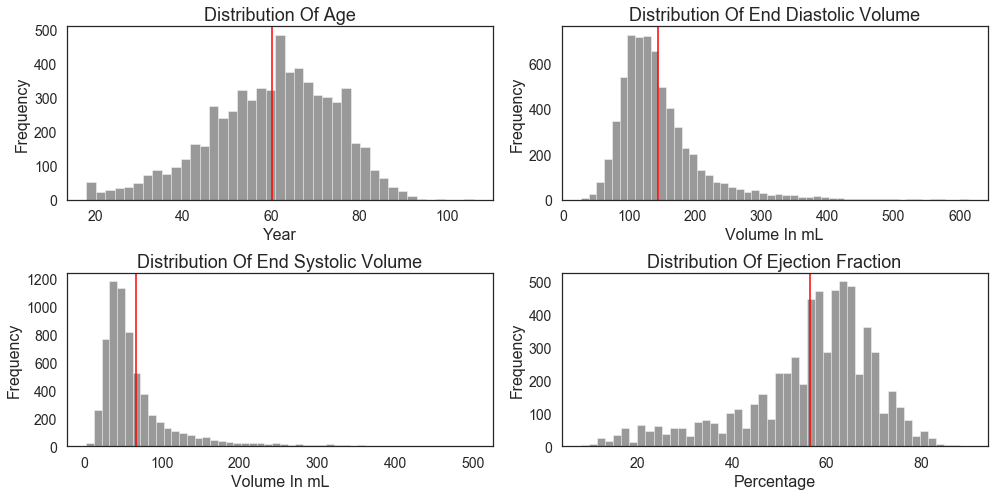

In [35]:
continuous_data_histograms(columns = ["age", "lvedv", 
                                      "lvesv", "lvef"], 
                           titles  = ["Age", "End Diastolic Volume",
                                      "End Systolic Volume", "Ejection Fraction"],
                           labels  = ["Year", "Volume In mL", 
                                      "Volume In mL", "Percentage"])

# A vertical red line is generated when the histograms are plotted
# which signifies the mean of the values.

- `age` follows a normal distribution, but it is skewed left.  This is a little surprising, because cardiac patients in general tend to be older than other patients.


- `LVEDV` and `LVESV` both have lognormal distributions, which is not suprising given that most biological data has a positive-skewed and rarely have values of 0.


- `LVEV` has an irregular distribution that appears to be skewed left, probably due to the fact that the healthy range is between 50% and 70%.  However, having an ejection fraction >70% is also a sign of disease which could explain the sharp drop off the graph.


Later on in feature engineering, we will take the log of `lvesv` because that will force it to have a more normal distribution which will make the models better.  However, `lvedv` is the target variable, so it will be left as is.

### Box Plots

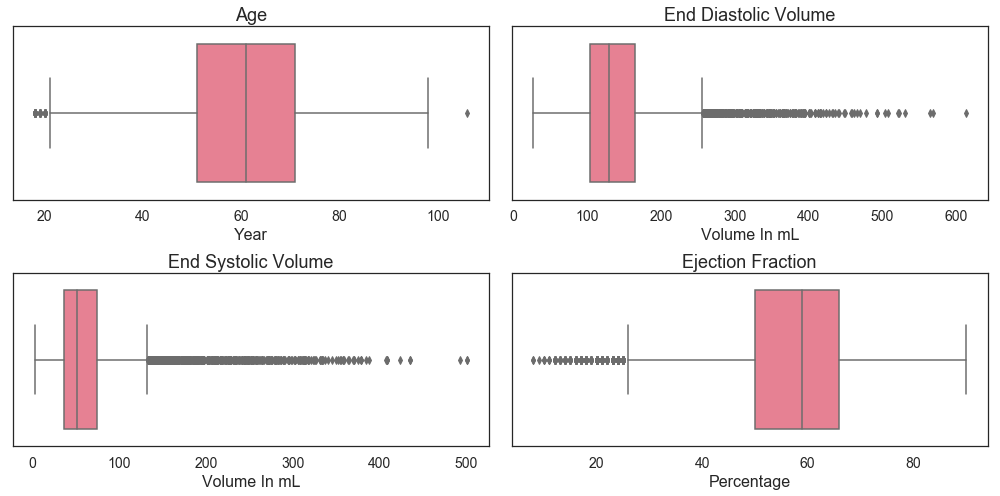

In [36]:
continuous_data_boxplots(columns = ["age", "lvedv", "lvesv", "lvef"], 
                         titles  = ["Age", "End Diastolic Volume",
                                    "End Systolic Volume", "Ejection Fraction"],
                         labels  = ["Year", "Volume In mL", 
                                    "Volume In mL", "Percentage"])

- `age` has a wide range, with a few outliers <20 years and >95 years which is not unexpected.  We expected the mean to be a little bit higher given that older people tend to have heart attacks more than younger people, but as it turns out people are having heart attacks at a younger ages.  [Source](https://www.heart.org/en/news/2018/11/12/heart-attacks-are-becoming-more-common-in-younger-people-especially-women).  Furthermore, given that the left whisker is longer than the right whisker, it is evident that the ages <60 vary more than >60.


- `lvedv` has a very tight distribution, but a significant number of high outliers which is a reflection of its lognormal distribution.


- `lvesv` has a very tight distribution, but a significant number of high outliers which is a reflection of its lognormal distribution.


- `lvef` also has a tight distribution, but is skewed left.  This is a reflection of the fact that people with heart disease are likely to have low ejection fractions (more blood left after the diastolic contraction).

### Scatter Plots

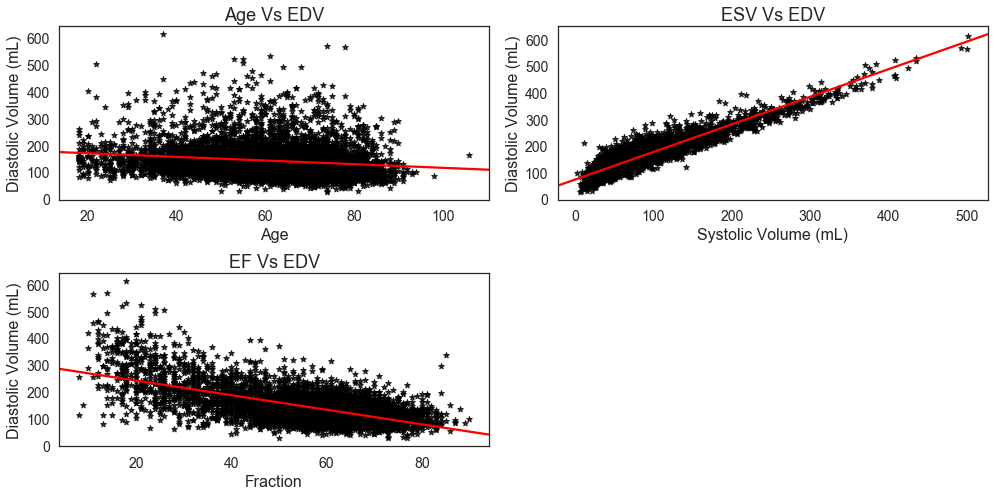

In [37]:
continuous_data_scatterplots(columns = ["age", "lvesv", "lvef"], 
                             titles  = ["Age", "ESV", "EF"],
                             labels  = ["Age", "Systolic Volume (mL)", 
                                        "Fraction"])

# The scatter plots are actually regression plots.
# The graph creates a regression line to show the 
# trend in the data

- `Age Vs LVEDV`: there is a negative linear relationship between the two, but it is not strong.  The EDV appears to be densest between the ages of 40 and 80.


- `LVESV Vs LVEDV`: there is a very strong positive relationship between the two given the fact that the the ESV is the volume when the ventricle is contracted, hence it will be directly related to the EDV.


- `LVEF Vs LVEDV`: there is a moderately strong negative relationship between the due because the ejection fraction is the SV divided by the DV.  This column will not be included in the models.

[Top](#Table-Of-Contents)

### Ordinal Data

### Functions

Rather than trying to plot all 44 categorical/ordinal columns at once, we broke them down into four groups:

- `segments_scr` encompasses the compasses that record scarification in each of the segments of the heart, i.e. columns that end in `_HE`.


- `segments_isc` is the same as `segments_scr` but instead records ischemia; all of the columns that end with `_ischemia`.


- `structure` is a list of cardiac structural measurements: thickness of the left ventricular wall, valvular regurgitation, and aortic stenosis.


- `lifestyle` refers to hypertension, hyperlipidemia, diabetes, and smoking status.

In [38]:
# Defining groups to visualize
# Rather than using plotting all ordinal columns at once,
# I'm breaking them down by similarity

segments_scr  = ['ba_he', 'bas_he', 'bis_he', 'bi_he', 
                 'bil_he', 'bal_he', 'ma_he', 'mas_he', 
                 'mis_he', 'mi_he','mil_he', 'mal_he', 
                 'aa_he', 'as_he', 'ai_he', 'al_he', 'apex_he']

segments_isc  = ['ba_ischemia', 'bas_ischemia', 'bis_ischemia', 
                'bi_ischemia', 'bil_ischemia', 'bal_ischemia', 
                'ma_ischemia', 'mas_ischemia','mis_ischemia', 
                'mi_ischemia', 'mil_ischemia', 'mal_ischemia', 
                'aa_ischemia', 'as_ischemia', 'ai_ischemia', 
                'al_ischemia',]

structure     = ['lv_wall_thickness', 'aortic_stenosis',
                 'aortic_reg', 'mitral_reg', 'tricusp_reg']

lifestyle      = ['sex','hypertension', 'hyperlipidemia', 
                 'diabetes', "smoker_status"]

# Adding the `smoker_status` column back

mri_cleaned["smoker_status"] = mri["smoker_status"].astype(str)

In [39]:
# See the previous plotting functions for comments

def plot_barcharts(columns, titles, labels):
    fig       = plt.figure(figsize = (20,30))
    count     = 0
    for c, column in enumerate(columns):
        count += 1
        ax    = fig.add_subplot(8, 3, count)
        title = titles[c]
        plt.title(f"{title}", size = 18)
        sns.countplot(mri[column])
        plt.xlabel(f"{labels[c]}", size = 16)
        plt.ylabel("Count", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

In [40]:
def sum_segment_scr_cols():
    
    # Delcaring empty variables for each value
    cat_0 = 0
    cat_1 = 0
    cat_2 = 0
    cat_3 = 0
    cat_4 = 0
    
    # Looping through each column's value counts
    # Adds the count and sets the variable equal to that
    for column in segments_scr:
        cat_0  += mri[column].value_counts()[0]
        cat_1  += mri[column].value_counts()[1]
        cat_2  += mri[column].value_counts()[2]
        cat_3  += mri[column].value_counts()[3]
        cat_4  += mri[column].value_counts()[4]
        
    # Creating a dataframe allows for easy visualization
    scar_total = pd.DataFrame(data    = [cat_0, cat_1, 
                                         cat_2, cat_3, 
                                         cat_4],
                              columns = ["count"])
    
    # Setting up a bar chart
    plt.figure(figsize = (10,5))
    sns.barplot(x    = scar_total.index,
                y    = "count",
                data = scar_total)
    plt.title("Presence Of Scar Tissue", size = 18)
    plt.xlabel("Level", size = 16)
    plt.ylabel("Frequency", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)

In [41]:
def sum_segment_isc_cols():
    
    # Declaring empty values for each value
    cat_0 = 0
    cat_1 = 0
    
    # Looping through each column's value counts
    # Adds the count and sets the variable equal to that
    for column in segments_scr:
        cat_0  += mri[column].value_counts()[0]
        cat_1  += mri[column].value_counts()[1]
        
    # Making a dataframe allows for easy visuals
    isc_total  = pd.DataFrame(data    = [cat_0, cat_1],
                              columns = ["count"])
    
    # Creating a bar plot
    plt.figure(figsize = (10,5))
    sns.barplot(x    = isc_total.index,
                y    = "count",
                data = isc_total)
    plt.title("Presence Of Ischemia", size = 18)
    plt.xlabel("Category", size = 16)
    plt.ylabel("Frequency", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)

[Top](#Table-Of-Contents)

### Bar Plots

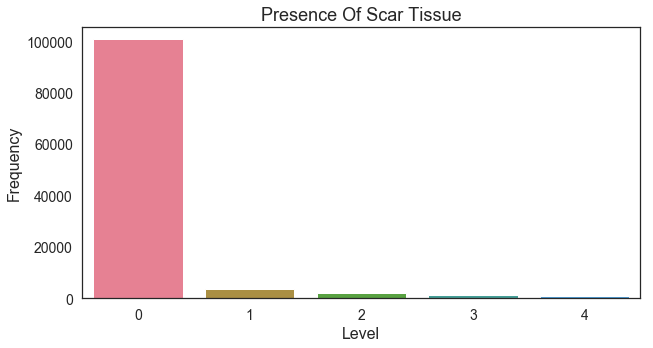

In [42]:
sum_segment_scr_cols()

The main takeaway is that by far most segments of the heart do not have any damage at all, which makes sense because it would be likely that damage across the entirety of the heart is near impossible: infarction is localized by the blockage of a given artery.

The data in the `segments_scr` list is ordinal, meaning that each category corresponds to a degree of scarification.  In this case, the scale is from 0 to 5:

| Scale | Scarification |
|:-----:|:--------------|
| 0     | None          |
| 1     | 25%           |
| 2     | 50%           |
| 3     | 75%           |
| 4     | Tissue death  |

These measurements were seen by the physician on a MRI scan and then classified at their discretion.

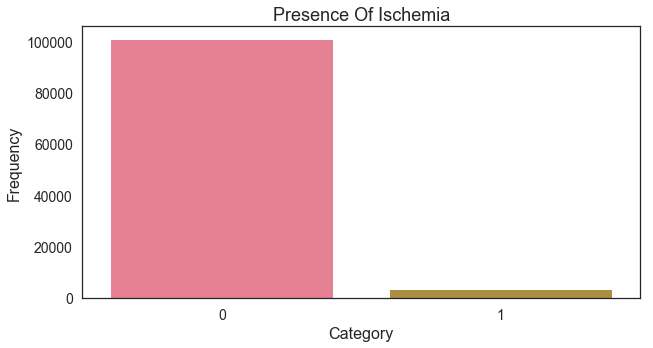

In [43]:
sum_segment_isc_cols()

This graph has a similar takeaway: by far most areas of the heart had no ischemia at the time the image was taken.  Ischemia is also localized by blockage of an artery, so an ischemic event would happen only in one place.

The data in the `segments_isc` list is binary, meaning that the columns simply record if there was ischemia (reduced blood-flow):

| Scale | Ischemia |
|:-----:|:---------|
| 0     | None     |
| 1     | Present  |

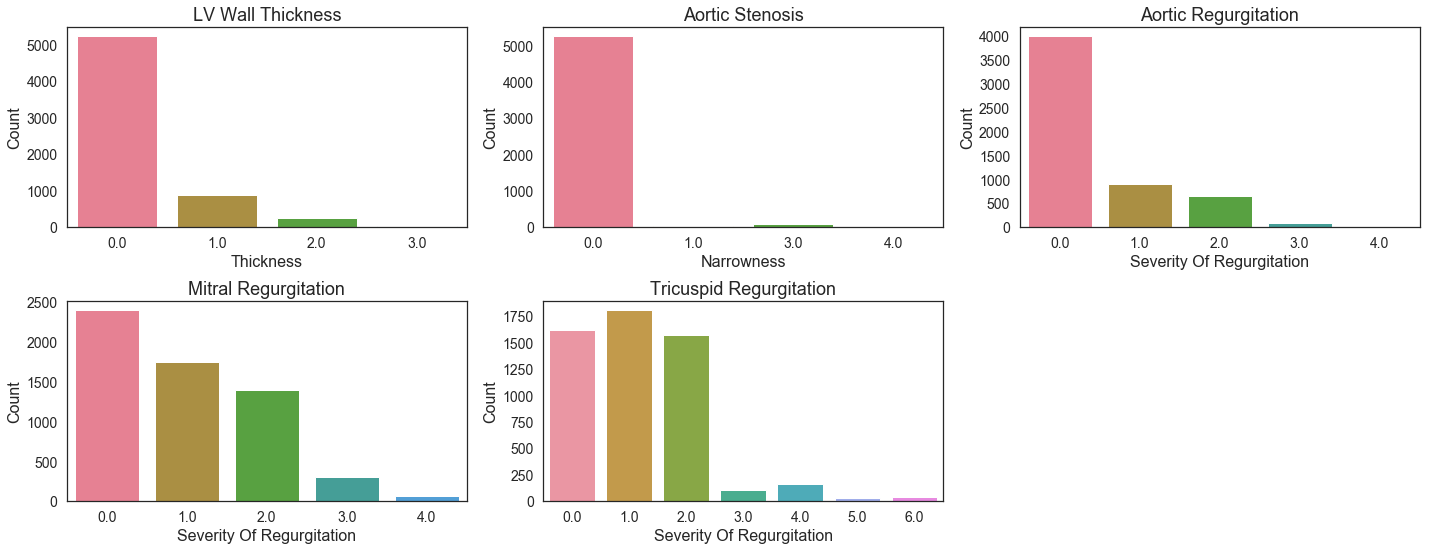

In [44]:
plot_barcharts(columns = structure, 
               titles  = ["LV Wall Thickness", "Aortic Stenosis",
                          "Aortic Regurgitation", "Mitral Regurgitation",
                          "Tricuspid Regurgitation"],
               labels  = ["Thickness", "Narrowness", "Severity Of Regurgitation",
                          "Severity Of Regurgitation", "Severity Of Regurgitation"])

Unfortunately, not all of these columns are on the same scale:


| Scale | LV Wall Thickness | Aortic Stenosis | Aortic Regurgitation | Mitral Regurgitation | Tricuspid Regurgitation |
|:-----:|:------------------|:----------------|:---------------------|:---------------------|:------------------------|
| 0     | Normal            | None            | Mild                 | Mild                 | None                    |
| 1     | Mild              | Trivial         | Mild-Moderate        | Mild-Moderate        | Trivial                 |
| 2     | Moderate          | Mild            | Moderate             | Moderate             | Mild                    |
| 3     | Severe            | Moderate        | Moderate-Severe      | Moderate-Severe      | Mild-Moderate           |
| 4     | -----             | Severe          | Severe               | Severe               | Moderate                |
| 5     | -----             | -----           | -----                | -----                | Moderate-Severe         |
| 6     | -----             | -----           | -----                | -----                | Severe                  |

We were not given a satisfactory answer as to why tricuspid regurgitation has a different scale than aortic and mitral regurgitation.

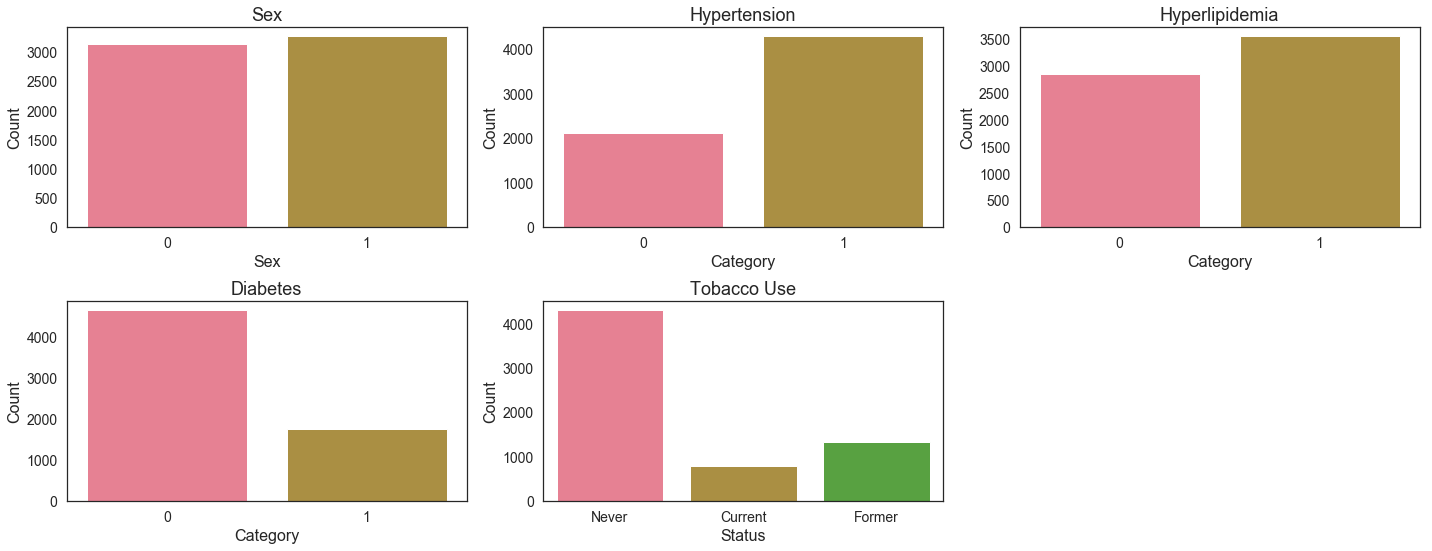

In [45]:
plot_barcharts(columns = lifestyle,
               titles  = ["Sex", "Hypertension", "Hyperlipidemia",
                          "Diabetes", "Tobacco Use"],
               labels = ["Sex", "Category", "Category", "Category",
                         "Status"])

For the above graphs:

| Scale | Sex    | Others Except Tobacco Use |
|:-----:|:-------|:--------------------------|
| 0     | Female | Negative, absent          |
| 1     | Male   | Positive, present         |

-----

- `Sex` is virtually evenly split, which surprised us because heart attacks are more associated with men than with women.


- `Hypertension` has a split that was expected because hyper tension is strongly correlated with occurance of cardiac disease.


- `Hyperlipidemia` also has a surprising split.  We expected that it would look more like the split in `Hypertension` because it is also a huge risk factor for heart diease.


- `Diabetes` was a little suprising because diabetes also is a risk factor for cardiovascular disease, but also because roughly 100 million American adults are pre-diabetic or have Type 2 Diabetes.  We were not told if this group includes those with Type 1 Diabetes.


- `Tobacco Use` was expected given that tobacco use has plummeted in recent decades amongst Americans. 

## Heat Map

In [46]:
# Creating a list of columns for the heat map

numeric_cols = ["age", "lvedv", "lvesv", "lvef"]

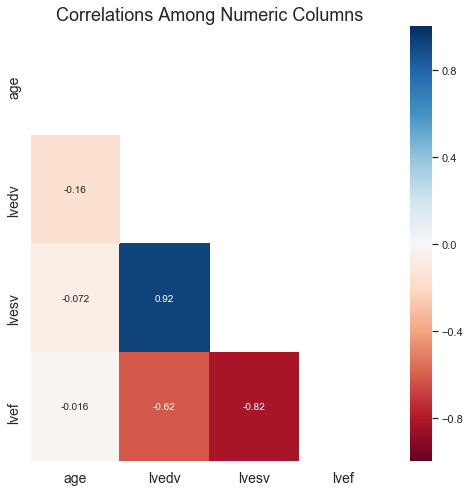

In [47]:
plt.figure(figsize = (8,8))
plt.title("Correlations Among Numeric Columns", size = 18)
corr = mri[numeric_cols].corr()
mask = np.zeros_like(corr)                                                                                
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr, cmap = "RdBu", mask = mask,
                vmin = -1, vmax = 1, annot = True)
plt.xticks(size = 14)
plt.yticks(size = 14);

We were fairly surprised by this heatmap.  While we were not at all surprised that EDV and ESV are so strongly correlated, we were surpised that age was not signficantly correlated with EDV, ESV, or EF at all.  We initially expected that EF would be strongly correlated with the two volume measurements, but the EF is actually done by diameter of the ventricles not by volume measurements.

[Top](#Table-Of-Contents)